In [54]:
import pandas as pd
pd.reset_option("all")
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.options.display.max_seq_items = 2000
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from tqdm import tqdm
from sklearn.model_selection import ParameterGrid,cross_val_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.

: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



In [2]:
df = pd.read_csv('fotmob_odds_form_df.csv', index_col = [0])

In [3]:
col_names = df.columns

In [4]:
threshold = 5
df_dropped = df.dropna(thresh=df.shape[1] - threshold + 1)
df = df.fillna(0)

In [5]:
qual_df = df.select_dtypes(include='object')

df = df.select_dtypes(include=['int', 'float'])

In [6]:
# non-penalty xg

df['np_xg_diff'] = df['expected_goals_(xg)_diff'] - df['xg_penalty_diff']
# efficiency metrics
df['efficiency_metric_diff'] = df['np_xg_diff'] / df['total_shots_diff']
# aggression factor
df['aggression_factor_diff'] = df['fouls_committed_diff'] + df['yellow_cards_diff'] + df['red_cards_diff']
# offensive/defensive balance
df['off_def_balance_diff'] = df['tackles_won_diff'] - df['successful_dribbles_diff']
# overall form difference
df['overall_form_diff'] = df['home_form_points_gained'] - df['away_form_points_gained']
# form efficiency
df['home_form_efficiency'] = df['home_form_goals_scored'] / df['home_form_goals_conceded']
df['away_form_efficiency'] = df['away_form_goals_scored'] / df['away_form_goals_conceded']
# shot quality
df['shot_quality'] = df['np_xg_diff'] / df['total_shots_diff']
# non-penalty xg conversion ratio
df['np_xg_conversion_ratio'] = df['score_diff'] / df['np_xg_diff']
# xg on target ratio
df['shot_quality_on_target'] = df['xg_on_target_(xgot)_diff'] / df['shots_on_target_diff']
# shot quality
df['xg_shot_quality'] = df['xg_on_target_(xgot)_diff'] / df['expected_goals_(xg)_diff']
# open-play xg efficiency
df['open_play_xg_efficiency'] = df['xg_open_play_diff'] / df['total_shots_diff']
# odds variability
df['odds_variability'] = df['std_0'] + df['std_1'] + df['std_2']
# predictability index
df['predictability_index'] = 1 / df['cv_odds']
# team discipline
df['discipline_score'] = df['fouls_committed_diff'] / (df['yellow_cards_diff'] + 3*df['red_cards_diff'])
# set-play efficiency
df['set_play_efficiency'] = df['xg_set_play_diff'] / (df['corners_diff'] + df['accurate_long_balls_diff'])
# possession efficiency
df['possession_efficiency'] = df['np_xg_diff'] / df['posession_diff']
# goal conversion ratio
df['goal_conversion_ratio'] = df['score_diff'] / df['expected_goals_(xg)_diff']
# possession conversion
df['possession_conversion'] = df['np_xg_diff'] / df['posession_diff']
# possession territory
df['possession_territory'] = df['own_half_diff'] / df['opposition_half_diff']
# possession effectiveness
df['possession_effectiveness'] = df['big_chances_diff'] / df['posession_diff']
# possession discipline
df['possession_discipline'] = df['fouls_committed_diff'] / df['posession_diff']
# pass efficiency
df['pass_efficiency'] = df['total_shots_diff'] / df['passes_diff']
# xg per pass
df['xg_per_pass'] = df['np_xg_diff'] / df['passes_diff']
# crossing efficiency
df['crossing_efficiency'] = df['shots_on_target_diff'] / df['accurate_crosses_diff']
# crossing xg efficiency
df['crossing_xg_efficiency'] = df['np_xg_diff'] / df['accurate_crosses_diff']
# opposition half pass efficiency
df['opposition_half_pass_efficiency'] = df['total_shots_diff'] / df['opposition_half_diff']
# big chance creation
df['big_chance_creation'] = df['big_chances_diff']/df['total_shots_diff']
df = df.replace([np.inf, -np.inf], np.nan)

df = df.fillna(0)

In [168]:
fdf = df[['total_shots_diff','big_chances_diff','shots_on_target_diff','xg_on_target_(xgot)_diff','passes_diff','score_diff', 'posession_diff',
        'std_0', 'std_1', 'std_2','skew_0', 'skew_1', 'skew_2', 'kurtosis_0', 'kurtosis_1', 'kurtosis_2','mean_0', 'mean_1', 'mean_2',
        'cv_odds', 'target','home_form_goal_difference', 'away_form_goal_difference', 'home_form_win_ratio','away_form_win_ratio',
        'home_form_win_streak','away_form_win_streak','home_form_scoring_ratio','away_form_scoring_ratio','np_xg_diff',
        'efficiency_metric_diff','shot_quality', 'np_xg_conversion_ratio','shot_quality_on_target', 'xg_shot_quality', 'open_play_xg_efficiency',
          'odds_variability', 'predictability_index','possession_efficiency', 'overall_form_diff']]

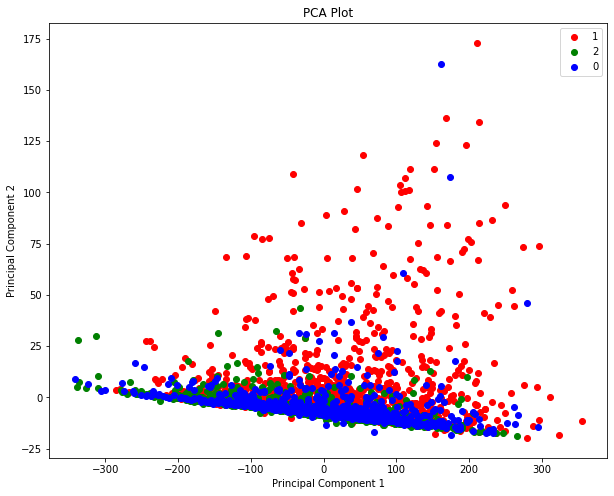

In [169]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming your DataFrame is called 'df'
# Extract the features and target
features = fdf.drop('target', axis=1).values
target = fdf['target'].values

# Perform PCA
pca = PCA(n_components=2)  # Set the desired number of components (2 in this case)
components = pca.fit_transform(features)

# Create a new DataFrame with the principal components and the target
pca_df = pd.DataFrame(data=components, columns=['PC1', 'PC2'])
pca_df['target'] = target

# Plot the results
plt.figure(figsize=(10, 8))
targets = pd.unique(target)  # Get unique target values
colors = ['r', 'g', 'b']  # Set colors for each target (you can customize this as needed)

for target, color in zip(targets, colors):
    indices = pca_df['target'] == target
    plt.scatter(pca_df.loc[indices, 'PC1'], pca_df.loc[indices, 'PC2'], c=color, label=target)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.title('PCA Plot')
plt.show()


In [56]:
def plot_evaluation_graphs(column_name, target):

    plt.figure(figsize=(10, 5))
    sns.boxplot(x=target, y=column_name, data=df, palette='Set2')
    plt.title('Relationship between {} and Target'.format(column_name))
    plt.show()

    plt.figure(figsize=(10, 5))
    sns.kdeplot(data=df, x=column_name, hue=target, fill=True, palette = 'Set2')
    plt.title('Distribution of {} for each class'.format(column_name))
    plt.show()

    plt.figure(figsize=(10, 5))
    sns.violinplot(x=target, y=column_name, data=df, palette='Set2')
    plt.title('Correlation between {} and Target'.format(column_name))
    plt.show()
    
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=column_name, y=target, data=df, palette='Set2', hue="target", alpha=0.7)
    plt.title('Relationship between {} and Target (Scatter Plot)'.format(column_name))
    plt.show()

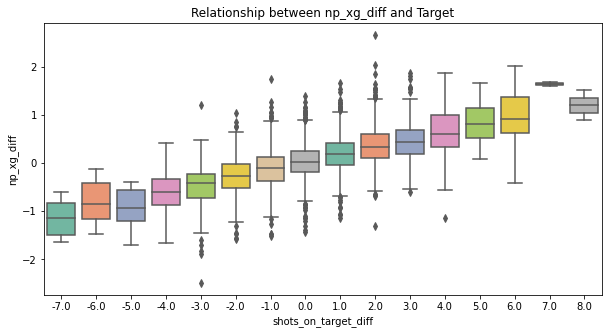

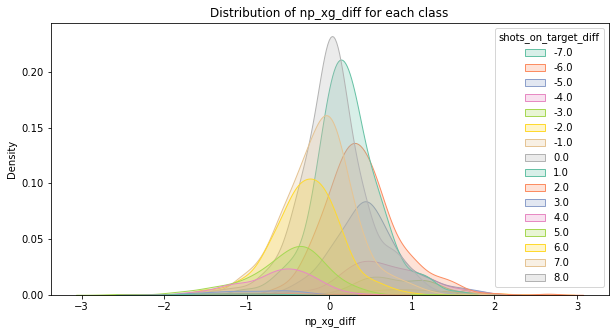

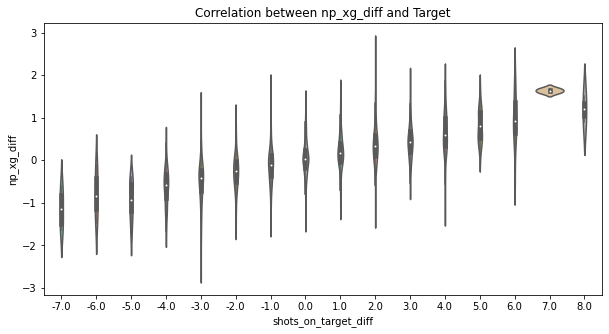

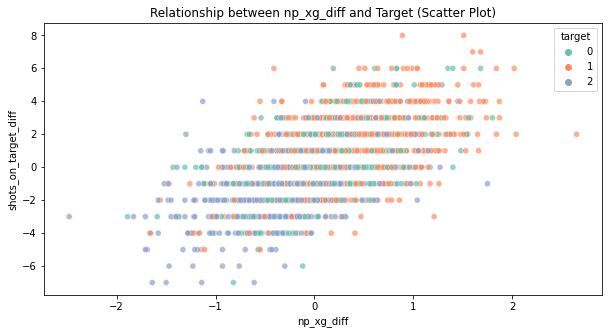

In [62]:
plot_evaluation_graphs('np_xg_diff', 'shots_on_target_diff')

In [64]:
df.shape

(2633, 135)

In [65]:
df.to_csv('final_df.csv')